In [102]:
from pina.problem import SpatialProblem
from pina import Condition,LabelTensor,Trainer
from pina.model import FeedForward
from pina.solvers import PINN
from pina.geometry import Difference, CartesianDomain, EllipsoidDomain
from pina.equation import Equation, FixedValue, SystemEquation
from pina.operators import grad, laplacian, div
import matplotlib.pyplot as plt

class Stokes(SpatialProblem):
    output_variables = ['ux', 'uy', 'P']
    spatial_domain = Difference([CartesianDomain({'x':[0, 2.2], 'y':[0, 0.41]}), EllipsoidDomain({'x':[0.15, 0.25], 'y':[0.15, 0.25]})])

    def laplace_equation(input_, output_):
        return - 0.01 * laplacian(output_,input_,components=['ux','uy'],d=['x','y']) + grad(output_,input_,components=['P'],d=['x','y'])

    def div_equation(input_, output_):
        return div(output_,input_,components=['ux','uy'],d=['x','y'])

    list_eq = [laplace_equation,div_equation]
    
    def partials_equation(input_, output_):
        return grad(output_, input_, components=['ux','uy'],d=['x']) - output_.extract('P')*torch.tensor([[1, 0]])

    def u_in_equation(input_, output_):
        uxuy = output_.extract(['ux', 'uy'])
        sol = torch.zeros_like(uxuy)
        sol[:, 1] = (3*0.4*input_.extract('y')*(0.41-input_.extract('y'))/(0.41**2)).flatten()
        return output_.extract(['ux', 'uy']) - sol

    conditions = {
        'gamma1': Condition(location=CartesianDomain({'x':[0, 2.2], 'y': 0.41}), equation=FixedValue(0.)),
        'gamma2': Condition(location=CartesianDomain({'x':[0, 2.2], 'y': 0}), equation=FixedValue(0.)),
        'gamma3': Condition(location=CartesianDomain({'x': 0, 'y':[0, 0.41]}), equation=Equation(u_in_equation)), # fixed value u_in, is it Equation or Fixed value
        'gamma4': Condition(location=CartesianDomain({'x': 2.2, 'y':[0, 0.41]}), equation=Equation(partials_equation)),
        'D': Condition(location=spatial_domain, equation=SystemEquation(list_eq))
    }

In [113]:
problem=Stokes()
problem.discretise_domain(1000, locations=['D'])
problem.discretise_domain(50, locations=['gamma1','gamma2','gamma3','gamma4'])

In [114]:
from pina import Plotter
pl = Plotter()

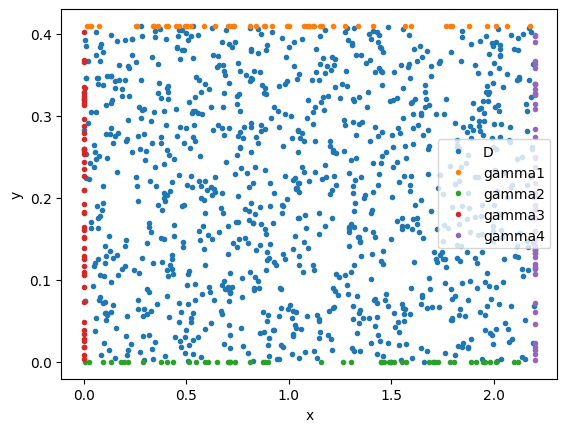

In [115]:
pl.plot_samples(problem)

In [116]:
import torch
model   = FeedForward(input_dimensions=2, output_dimensions=3, layers=[40, 40, 40], func=torch.nn.Tanh)  # MLP()
solver  = PINN(problem=problem, model=model)
trainer = Trainer(solver, max_epochs=10, accelerator='cpu')
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type    | Params | Mode 
------------------------------------------------
0 | _loss       | MSELoss | 0      | train
1 | _neural_net | Network | 3.5 K  | train
------------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
C:\Users\zaire\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


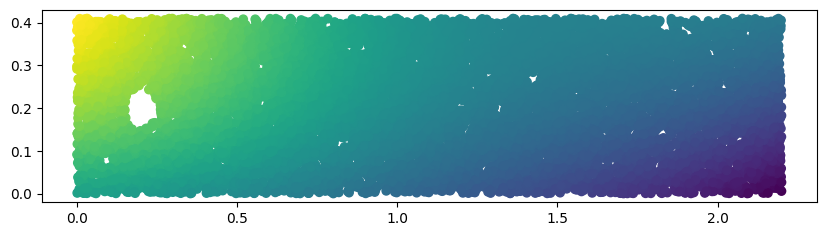

In [118]:
with torch.no_grad():
    pts = problem.spatial_domain.sample(10000)
    output_ = solver(pts)
    mag_u = torch.sqrt(output_.extract('ux')**2 + output_.extract('uy')**2)
    plt.figure(figsize=(10, 2.5))
    plt.scatter(pts.extract('x'), pts.extract('y'), c=output_.extract('ux'))

In [ ]:
# 1. write everything in .py
# 2. make function for plotting(vary points, things you are plotting)
# 3. read trainer paper - 7.3 Stokes flow - understand each concept(look up unknown concepts)
# 4. Lowest error possible
# 4. check that problem is correct